# MSEE UQ short course:  The $\texttt{UQpy}$ library

Application of surrogate modeling using the $\texttt{UQpy}$ module $\texttt{surrogates}$.

Detailed instructions on how to use this module can be found in the $\texttt{UQpy}$ documentation.

https://uqpyproject.readthedocs.io/en/latest/surrogates/index.html

# Exercise 1

### Polynomial Chaos

Build a PCE surrogate for the 1-D Bouc-Wen $\texttt{Python}$ model. In this case, randomness is assumed in the systems' parameter $r_{0}$ which is uniformly distributed in the range [0.5, 3.5]. The response of interest is the maximum displacement $z(t)$ of the system.

### Step 1

Create a distribution object for the random variable (see Day 1 activities).

In [ ]:
# Solution
from UQpy.distributions.collection.Uniform import Uniform

distribution=Uniform(0.5, 3.0)

### Step 2

Create a $\texttt{MonteCarloSampling}$ object (see Day 1 activities):
- generate 30 realizations of $r_0$ that will serve as our training input set.
- generate 20 realizations of $r_0$ that will serve as our validation input set.

In [ ]:
# Solution
from UQpy.sampling.MonteCarloSampling import MonteCarloSampling

training_sampling = MonteCarloSampling(distributions=distribution, nsamples=30)
training_samples=training_sampling.samples

validation_sampling = MonteCarloSampling(distributions=distribution, nsamples=20)
validation_samples = validation_sampling.samples

### Step 3

Run the 1-D Bouc-Wen computational model using $\texttt{RunModel}$ class of $\texttt{UQpy}$ (see Day 1 activities):
- for the training input set.
- for the validation input set.

In [ ]:
# Solution
from UQpy.run_model.RunModel import RunModel
from UQpy.run_model.model_execution.PythonModel import PythonModel
from UQpy.sampling.MonteCarloSampling import MonteCarloSampling
import numpy as np
import matplotlib.pyplot as plt

m=PythonModel(model_script='model_1D.py', 
              model_object_name='boucwen_runmodel', var_names=['r0'])
boucwen = RunModel(model=m)
boucwen.run(samples=training_samples)

qoi= boucwen.qoi_list

maximum_displacement = boucwen.qoi_list[:30]

boucwen.run(samples=validation_samples)

maximum_displacement_validation=boucwen.qoi_list[-20:]

In [ ]:
len(maximum_displacement)

### Step 4

Create the PCE surrogate to approximate the response function (i.e., maximum displacement $\max(z(t))$ of the system. Compute the PCE coefficients using least square regression. Compute the validation error.

### Step 4.1:

Import classes  $\texttt{PolynomialChaosExpansion}$, $\texttt{TensorProductBasis}$ and $\texttt{LeastSquareRegression}$, from $\texttt{UQpy.surrogates.polynomial}\_\texttt{chaos}$ module.


In [ ]:
# Solution
from UQpy.surrogates.polynomial_chaos import PolynomialChaosExpansion, TensorProductBasis, LeastSquareRegression

### Step 4.2:

Define a 'polynomial_basis' object using the $\texttt{TensorProductBasis}$ class. Provide as input to the class the distribution object of the random variable, and the maximum  PCE order p=1.

In [ ]:
# Solution
polys = TensorProductBasis(distribution, max_degree=10)
polys.polynomials_number

### Step 4.3:

Define a least squares regression object using the $\texttt{LeastSquaresRegression}$ class. 

In [ ]:
# Solution
lstsq = LeastSquareRegression()

### Step 4.4:

Define a pce object using the $\texttt{PolynomialChaosExpansion}$ class. Provide as input method the regression object and polynomial basis created in the previous steps.

In [ ]:
# Solution
pce = PolynomialChaosExpansion(polynomial_basis=polys, 
                               regression_method=lstsq)

### Step 4.5:

Calculate the coefficients using the $\texttt{fit}$ method of the $\texttt{PCE}$ object. Provide the training data set (input-output pairs).

In [ ]:
# Solution
pce.fit(training_samples,np.array(maximum_displacement).reshape(30,1))

### Step 4.6:

Predict the response for the validation input set using the $\texttt{predict}$ method of the $\texttt{PCE}$ object.

In [ ]:
# Solution
prediction_sampling=MonteCarloSampling(distributions=[distribution],
                                       nsamples=100)
prediction_results=pce.predict(prediction_sampling.samples)

import matplotlib.pyplot as plt

domain=np.linspace(0.5, 3.5, 100)
prediction_results=pce.predict(domain)
plt.plot(domain, prediction_results)
plt.scatter(training_samples, np.array(maximum_displacement).reshape(30,1))



### Step 4.7:

Compute the validation error:
- Compute the validation error using the $\texttt{validation}\_\texttt{error}$ method of the pce object.

In [ ]:
# Solution
error = pce.validation_error(validation_sampling.samples, 
                             np.array(maximum_displacement_validation))
print('Error from least squares regression is: ', error)

err= pce.leaveoneout_error()
err

# Exercise 2 

## Ishigami

Build a PCE surrogate for the Ishigami function.

\begin{align*}
    & f(x_1, x_2, x_3)=sin(x_1)+a \cdot sin^2(x_2)+b \cdot x_3^4 \cdot sin(x_1)
\end{align*}

The parameters $a$ and $b$ have the following values:

- $a=7$
- $b=0.1$

The Ishigami function has three random inputs, namely $x_1$, $x_2$ and $x_3$ distributed as follows:

\begin{align*}
    & \texttt{x}_1 \sim \mathcal{U}(-\pi, \pi) \\
    & \texttt{x}_2 \sim \mathcal{U}(-\pi, \pi) \\
    & \texttt{x}_3 \sim \mathcal{U}(-\pi, \pi) 
\end{align*}

Consider that all the above parameters follow a Joint Independent distribution.

Create a PCE surrogate of the Ishigami function using fifth order polynomials, $\texttt{TensorProductBasis}$ and $\texttt{LeastSquareRegression}$. After fitting the surrogate estimate the sensitivities of each one of the three parameters by using the $\texttt{PceSensitivity}$ class.

### Step 1
Initially, import the required $\texttt{UQpy}$ classes $\texttt{Uniform}$, $\texttt{JointIndependent}$ to define the distributions of the parameters.

In [ ]:
import numpy as np
import math
from UQpy.distributions import Uniform, JointIndependent
from UQpy.surrogates import *

### Step 1.1

Create three (3) different $\texttt{Uniform}$ distribution objects for each one of the model parameters and merge them into a a single multivariate distribution object by using the $\texttt{JointIndependent}$ class.

In [ ]:
# input distributions
dist1 = Uniform(loc=-np.pi, scale=2*np.pi)
dist2 = Uniform(loc=-np.pi, scale=2*np.pi)
dist3 = Uniform(loc=-np.pi, scale=2*np.pi)
marg = [dist1, dist2, dist3]
joint = JointIndependent(marginals=marg)

### Step 1.2

Define the Ishigami, as a $\texttt{Python}$ function that accepts as input the a list of the models parameters $x_1$, $x_2$ and $x_3$

In [ ]:
def ishigami(xx):
    """Ishigami function"""
    a = 7
    b = 0.1
    term1 = np.sin(xx[0])
    term2 = a * np.sin(xx[1])**2
    term3 = b * xx[2]**4 * np.sin(xx[0])
    return term1 + term2 + term3

### Step 2

- Given that the maximum polynomial degree is 5, construct a polynomial basis using the $\texttt{TensorProductBasis}$ class. 
- The size of the basis can then be retrieved with the aid of the $\texttt{polynomials}\_\texttt{number}$ attribute of the $\texttt{TensorProductBasis}$ object.

In [ ]:
# maximum polynomial degree
P = 14

# construct total-degree polynomial basis
polynomial_basis = TensorProductBasis(joint, P)

# check the size of the basis
print('Size of PCE basis:', polynomial_basis.polynomials_number)

### Step 2.1

Create a set of sample points and their values on the $\texttt{Ishigami}$ function that will be used for fitting the $\texttt{PCE}$ surrogate.

- Create samples of the domain by using the $\texttt{rvs}$ method of the $\texttt{JointIndependent}$ distribution created in **Step 1.1**. We choose the number of samples to be equal to five times the size of the polynomial basis, computed in **Step 2**

- Given the generated points use the $\texttt{Ishigami}$ function to compute their corresponding values.

In [ ]:
# create training data
sample_size = int(polynomial_basis.polynomials_number*5)
print('Size of experimental design:', sample_size)

# realizations of random inputs
xx_train = joint.rvs(sample_size)
# corresponding model outputs
yy_train = np.array([ishigami(x) for x in xx_train])

### Step 3

Create and fit the $\texttt{PCE}$ surrogate. 

- The first step is to define the regression algorithm of our choice. In this case we use the $\texttt{LeastSquareRegression}$ class defined in $\texttt{UQpy}$.
- Define the $\texttt{PolynomialChaosExpansion}$ object by using the polynomial basis and regression method that are already instantiated.
- Fit the pce surrogate by using the $\texttt{fit}$ method of the $\texttt{PolynomialChaosExpansion}$ class instantiated. Both the samples of the domain, as well their values on the $\texttt{Ishigami}$ function must be provided as input.

In [ ]:
least_squares = LeastSquareRegression()
pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis,
                               regression_method=least_squares)

pce.fit(xx_train, yy_train)


### Step 4

Calculate the Sensitivity indices using fitted $\texttt{PCE}$ surrogate.

- $\texttt{UQpy}$ supports the direct evaluation of the sensitivity indices using the $\texttt{Pce}\_\texttt{Sensitivity}$ class. The only input required for this class is the fitted $\texttt{PCE}$ surrogate of **Step 3**.
- By invoking the $\texttt{run}$ method of the $\texttt{PceSensitivity}$ class, all first order, total order and generalized Sobol's indices are computed.
- Retrieve and print the values of the first and total order indices, using the $\texttt{first}\_\texttt{order}\_\texttt{indices}$ and $\texttt{total}\_\texttt{order}\_\texttt{indices}$ attributes of the instantiated $\texttt{PceSensitivity}$

In [ ]:
from UQpy.sensitivity import PceSensitivity

pce_sensitivity = PceSensitivity(pce)

pce_sensitivity.run()

sobol_first = pce_sensitivity.first_order_indices
sobol_total = pce_sensitivity.total_order_indices
print('First-order Sobol indices:')
print(sobol_first)
print('Total-order Sobol indices:')
print(sobol_total)

# Exercise 3 

## Rosenbrock

Build a PCE surrogate for Rosenbrock function.

\begin{align*}
    f(x)= \sum_{i=1}^{d-1}[100(x_{i+1}-x_i^2)^2+(x_i-1)^2]
\end{align*}

The Rosenbrock function has a multitude of random variables equal to $\texttt{d}$. Consider 5 different dimension that all are uniformly distributed in the range $\mathcal{U}(-5, 10)$

Create a PCE surrogate of the Ishigami function using fifth order polynomials and $\texttt{TensorProductBasis}$ and $\texttt{LeastSquareRegression}$. After fitting the surrogate estimate the sensitivities of each one of the three parameters by using the $\texttt{PceSensitivity}$ class.

### Step 1
Initially, import the required $\texttt{UQpy}$ classes $\texttt{Uniform}$, $\texttt{JointIndependent}$ to define the distributions of the parameters.

In [ ]:
import numpy as np
import math
from UQpy.distributions import Uniform, JointIndependent
from UQpy.surrogates import *

### Step 1.1

Create five (5) different $\texttt{Uniform}$ distribution objects for each one of the model parameters and merge them into a a single multivariate distribution object by using the $\texttt{JointIndependent}$ class.

In [ ]:
# input distributions
dist1 = Uniform(loc=-5, scale=15)
dist2 = Uniform(loc=-5, scale=15)
dist3 = Uniform(loc=-5, scale=15)
dist4 = Uniform(loc=-5, scale=15)
dist5 = Uniform(loc=-5, scale=15)
marg = [dist1, dist2, dist3, dist4, dist5]
joint = JointIndependent(marginals=marg)

### Step 1.2

Define the Rosenbrock, as a $\texttt{Python}$ function that accepts as input the a list of the models parameters $x_1$ to $x_5$

In [ ]:
def rosenbrock(xx):
    """Rosenbrock function"""
    a = 7
    b = 0.1
    s=0
    for i in range(len(xx)-1):
        s+=100*((xx[i+1]-xx[i]**2)**2+(xx[i]-1)**2)   
    return s

### Step 2

- For maximum polynomial degrees equal $[1,2,5,10,50]$ calculate the size of the polynomial basis generated using the $\texttt{TensorProductBasis}$ class.

In [ ]:
# maximum polynomial degree
P = 10

# construct total-degree polynomial basis
polynomial_basis = TensorProductBasis(joint, P)

# check the size of the basis
print('Size of PCE basis:', polynomial_basis.polynomials_number)

polynomial_basis1 = TotalDegreeBasis(joint, P,0.5)
# check the size of the basis
print('Size of PCE basis:', polynomial_basis1.polynomials_number)

In [ ]:
basis = HyperbolicBasis(joint, P, hyperbolic=0.5)
print('Size of PCE basis:', basis.polynomials_number)

### Step 2.1

Create a set of samples points and their values on the $\texttt{Rosenbrock}$ function that will be used for fitting the $\texttt{PCE}$ surrogate.

- Create samples of the domain by using the $\texttt{rvs}$ method of the $\texttt{JointIndependent}$ distribution created in **Step 1.1**. We choose the number of samples to be equal to five times the size of the polynomial basis, computed in **Step 2**

- Given the generated points use the $\texttt{Rosenbrock}$ function to compute their corresponding values.

In [ ]:
# create training data
sample_size = int(polynomial_basis1.polynomials_number*5)
print('Size of experimental design:', sample_size)

# realizations of random inputs
xx_train = joint.rvs(sample_size)
# corresponding model outputs
yy_train = np.array([rosenbrock(x) for x in xx_train])

### Step 3

Create and fit the $\texttt{PCE}$ surrogate. 

- The first step is to define the regression algorithm of our choice. In this case we use the $\texttt{LeastSquareRegression}$ class defined in $\texttt{UQpy}$.
- Define the $\texttt{PolynomialChaosExpansion}$ object by using the polynomial basis and regression method that are already instantiated.
- Fit the pce surrogate by using the $\texttt{fit}$ method of the $\texttt{PolynomialChaosExpansion}$ class instantiated. Both the samples of the domain, as well their values on the $\texttt{Rosenbrock}$ function must be provided as input.

In [ ]:
least_squares = LeastSquareRegression()
pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis1, 
                               regression_method=least_squares)

pce.fit(xx_train, yy_train)


### Step 4

For each one of the max polynomial degrees $[1, 2, 5, 10]$ evaluate the validation error at a set of 100 validation points randomly generated in the Rosenbrock function definition domain $[-5, 10]^5$

In [ ]:
# realizations of random inputs
xx_val = joint.rvs(100)
# corresponding model outputs
yy_val = np.array([rosenbrock(x) for x in xx_val])

mae = []
for degree in [1, 2, 5, 10]:
    # define PCE
    polynomial_basis = TotalDegreeBasis(joint, degree, 0.5)
    least_squares = LeastSquareRegression()
    pce_metamodel = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, 
                                             regression_method=least_squares)

    # create training data
    np.random.seed(1)  # fix random seed for reproducibility
    sample_size = int(pce_metamodel.polynomials_number * 5)
    xx_train = joint.rvs(sample_size)
    yy_train = np.array([rosenbrock(x) for x in xx_train])

    # fit PCE coefficients
    pce_metamodel.fit(xx_train, yy_train)

    print('Polynomial degree:', degree)
    print('Mean absolute error:', pce_metamodel.validation_error(xx_val,
                                                                 yy_val))
    print(' ')

# Exercise 4 


### Gaussian process


Build a Gaussian Process surrogate for 1-D contact sphere model. In the indentation test model randomness is assumed in the parameter $k$ follows a Lognormal distribution, with the parameters of the underlying Gaussian distribution being: $\mu$ = 1e5 and standard deviation $\sigma=2e4$. The parameters of the lognormal distribution in this case are $s=0.19804$ and $scale=98058.0675$ ($loc$=0.0). Build a Kriging surrogate to approximate the response function of the maximum displacement at the identation point. 

### Step 1

Create a distribution object for the random variable (see Day 1 activities).

In [1]:
# Solution
from UQpy.distributions import Lognormal
dist1 = Lognormal(s=0.19804, scale=98058.0675, loc=0.0) 

### Step 2

Create a $\texttt{LatinHypercubeSampling}$ object (see Day 1 activities):
- generate 20 realizations of $f_0$ that will serve as our training input set.

In [2]:
# Solution
from UQpy.sampling import LatinHypercubeSampling
training_sampling = LatinHypercubeSampling(distributions=dist1, 
                                           nsamples=20)
training_samples = training_sampling.samples.reshape(20,1)



### Step 3

Run the 1-D contact sphere model using $\texttt{RunModel}$ class of $\texttt{UQpy}$ (see Day 1 activities):
- for the training input set.

In [3]:
# Solution
from UQpy.run_model.RunModel import RunModel
from UQpy.run_model.model_execution.ThirdPartyModel import ThirdPartyModel

m1=ThirdPartyModel(model_script='PythonAsThirdParty_model.py', 
                   model_object_name='run_model',
                   input_template='elastic_contact_sphere.py', 
                   var_names=['k'],
                   output_script='process_3rd_party_output.py', 
                   output_object_name='read_output')

model_serial_third_party=RunModel(model=m1)

model_serial_third_party.run(samples=training_samples)
qoi = model_serial_third_party.qoi_list

maximum_displacement=list(map(abs, qoi[:20]))

/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_0/InputFiles/elastic_contact_sphere_0.py
/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_0/elastic_contact_sphere_0.py
cp -r "/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_0/InputFiles/elastic_contact_sphere_0.py" "/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_0/elastic_contact_sphere_0.py"
python3 simple.py elastic_contact_sphere_0.py
sfepy: left over: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'absolute_import', 'data_dir', 'stiffness_from_lame', 'k', 'f0', 'main', 'verbose', '_filename']
sfepy: reading mesh (/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_0/cube_medium_hexa.mesh)...
sfepy:   number of vertices: 13

sfepy: left over: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'absolute_import', 'data_dir', 'stiffness_from_lame', 'k', 'f0', 'main', 'verbose', '_filename']
sfepy: reading mesh (/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_2/cube_medium_hexa.mesh)...
sfepy:   number of vertices: 1331
sfepy:   number of cells:
sfepy:     3_8: 1000
sfepy: ...done in 0.01 s
sfepy: creating regions...
sfepy:     Omega
sfepy:     Bottom
sfepy:     Top
sfepy: ...done in 0.01 s
sfepy: equation "elasticity":
sfepy: dw_lin_elastic.2.Omega(solid.D, v, u)
     + dw_contact_sphere.2.Top(cs.f, cs.c, cs.r, v, u)
     = 0
sfepy: using solvers:
                ts: no ts
               nls: newton
                ls: ls
sfepy: updating variables...
sfepy: ...done
sfepy: setting up dof connectivities...
sfepy: ...done in 0.00 s
sfepy: matrix shape: (3630, 3630)
sfepy: assembling matrix graph...
sfepy: 

sfepy: left over: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'absolute_import', 'data_dir', 'stiffness_from_lame', 'k', 'f0', 'main', 'verbose', '_filename']
sfepy: reading mesh (/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_4/cube_medium_hexa.mesh)...
sfepy:   number of vertices: 1331
sfepy:   number of cells:
sfepy:     3_8: 1000
sfepy: ...done in 0.01 s
sfepy: creating regions...
sfepy:     Omega
sfepy:     Bottom
sfepy:     Top
sfepy: ...done in 0.01 s
sfepy: equation "elasticity":
sfepy: dw_lin_elastic.2.Omega(solid.D, v, u)
     + dw_contact_sphere.2.Top(cs.f, cs.c, cs.r, v, u)
     = 0
sfepy: using solvers:
                ts: no ts
               nls: newton
                ls: ls
sfepy: updating variables...
sfepy: ...done
sfepy: setting up dof connectivities...
sfepy: ...done in 0.00 s
sfepy: matrix shape: (3630, 3630)
sfepy: assembling matrix graph...
sfepy: 

sfepy: left over: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'absolute_import', 'data_dir', 'stiffness_from_lame', 'k', 'f0', 'main', 'verbose', '_filename']
sfepy: reading mesh (/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_6/cube_medium_hexa.mesh)...
sfepy:   number of vertices: 1331
sfepy:   number of cells:
sfepy:     3_8: 1000
sfepy: ...done in 0.01 s
sfepy: creating regions...
sfepy:     Omega
sfepy:     Bottom
sfepy:     Top
sfepy: ...done in 0.01 s
sfepy: equation "elasticity":
sfepy: dw_lin_elastic.2.Omega(solid.D, v, u)
     + dw_contact_sphere.2.Top(cs.f, cs.c, cs.r, v, u)
     = 0
sfepy: using solvers:
                ts: no ts
               nls: newton
                ls: ls
sfepy: updating variables...
sfepy: ...done
sfepy: setting up dof connectivities...
sfepy: ...done in 0.00 s
sfepy: matrix shape: (3630, 3630)
sfepy: assembling matrix graph...
sfepy: 

sfepy: left over: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'absolute_import', 'data_dir', 'stiffness_from_lame', 'k', 'f0', 'main', 'verbose', '_filename']
sfepy: reading mesh (/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_8/cube_medium_hexa.mesh)...
sfepy:   number of vertices: 1331
sfepy:   number of cells:
sfepy:     3_8: 1000
sfepy: ...done in 0.01 s
sfepy: creating regions...
sfepy:     Omega
sfepy:     Bottom
sfepy:     Top
sfepy: ...done in 0.01 s
sfepy: equation "elasticity":
sfepy: dw_lin_elastic.2.Omega(solid.D, v, u)
     + dw_contact_sphere.2.Top(cs.f, cs.c, cs.r, v, u)
     = 0
sfepy: using solvers:
                ts: no ts
               nls: newton
                ls: ls
sfepy: updating variables...
sfepy: ...done
sfepy: setting up dof connectivities...
sfepy: ...done in 0.00 s
sfepy: matrix shape: (3630, 3630)
sfepy: assembling matrix graph...
sfepy: 

sfepy: left over: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'absolute_import', 'data_dir', 'stiffness_from_lame', 'k', 'f0', 'main', 'verbose', '_filename']
sfepy: reading mesh (/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_10/cube_medium_hexa.mesh)...
sfepy:   number of vertices: 1331
sfepy:   number of cells:
sfepy:     3_8: 1000
sfepy: ...done in 0.01 s
sfepy: creating regions...
sfepy:     Omega
sfepy:     Bottom
sfepy:     Top
sfepy: ...done in 0.01 s
sfepy: equation "elasticity":
sfepy: dw_lin_elastic.2.Omega(solid.D, v, u)
     + dw_contact_sphere.2.Top(cs.f, cs.c, cs.r, v, u)
     = 0
sfepy: using solvers:
                ts: no ts
               nls: newton
                ls: ls
sfepy: updating variables...
sfepy: ...done
sfepy: setting up dof connectivities...
sfepy: ...done in 0.00 s
sfepy: matrix shape: (3630, 3630)
sfepy: assembling matrix graph...
sfepy:

sfepy: left over: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'absolute_import', 'data_dir', 'stiffness_from_lame', 'k', 'f0', 'main', 'verbose', '_filename']
sfepy: reading mesh (/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_13/cube_medium_hexa.mesh)...
sfepy:   number of vertices: 1331
sfepy:   number of cells:
sfepy:     3_8: 1000
sfepy: ...done in 0.01 s
sfepy: creating regions...
sfepy:     Omega
sfepy:     Bottom
sfepy:     Top
sfepy: ...done in 0.01 s
sfepy: equation "elasticity":
sfepy: dw_lin_elastic.2.Omega(solid.D, v, u)
     + dw_contact_sphere.2.Top(cs.f, cs.c, cs.r, v, u)
     = 0
sfepy: using solvers:
                ts: no ts
               nls: newton
                ls: ls
sfepy: updating variables...
sfepy: ...done
sfepy: setting up dof connectivities...
sfepy: ...done in 0.00 s
sfepy: matrix shape: (3630, 3630)
sfepy: assembling matrix graph...
sfepy:

python3 simple.py elastic_contact_sphere_15.py
sfepy: left over: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'absolute_import', 'data_dir', 'stiffness_from_lame', 'k', 'f0', 'main', 'verbose', '_filename']
sfepy: reading mesh (/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_15/cube_medium_hexa.mesh)...
sfepy:   number of vertices: 1331
sfepy:   number of cells:
sfepy:     3_8: 1000
sfepy: ...done in 0.01 s
sfepy: creating regions...
sfepy:     Omega
sfepy:     Bottom
sfepy:     Top
sfepy: ...done in 0.01 s
sfepy: equation "elasticity":
sfepy: dw_lin_elastic.2.Omega(solid.D, v, u)
     + dw_contact_sphere.2.Top(cs.f, cs.c, cs.r, v, u)
     = 0
sfepy: using solvers:
                ts: no ts
               nls: newton
                ls: ls
sfepy: updating variables...
sfepy: ...done
sfepy: setting up dof connectivities...
sfepy: ...done in 0.00 s
sfepy: matrix shape: (3630,

/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_18/InputFiles/elastic_contact_sphere_18.py
/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_18/elastic_contact_sphere_18.py
cp -r "/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_18/InputFiles/elastic_contact_sphere_18.py" "/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_18/elastic_contact_sphere_18.py"
python3 simple.py elastic_contact_sphere_18.py
sfepy: left over: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'absolute_import', 'data_dir', 'stiffness_from_lame', 'k', 'f0', 'main', 'verbose', '_filename']
sfepy: reading mesh (/Users/dimitris/Desktop/Day2/Day2_InClassExercises_Solutions/Model_Runs_2022_05_26_11_40_945775/run_18/cube_medium_hexa.mesh)...
sfepy:   number of ve

### Step 4

Create the Gaussian Process surrogate to approximate the response function (i.e., maximum displacement at the identation point). 

### Step 4.1:

Import class  $\texttt{GaussianProcessRegression}$ from $\texttt{UQpy.surrogates.gaussian}\_\texttt{process}$ module.

In [4]:
# Solution
from UQpy.surrogates.gaussian_process import *

### Step 4.2:

Instantiate a $\texttt{GaussianProcessRegression}$ object. Select:

1. Linear regression model ($\texttt{LinearRegression}$) to evaluate the basis functions and their coefficients.
2. Radial Basis Function kernel ($\texttt{RBF}$) to define similarity between samples.

In [5]:
# Solution
K = GaussianProcessRegression(regression_model=LinearRegression(), 
                              kernel=RBF(),hyperparameters=[1, 0.1])

### Step 4.3:

Calculate the hyperparameters using the $\texttt{fit}$ method of the $\texttt{GaussianProcessRegression}$ object. Provide the training data set (input-output pairs). Print the regression coefficients.

In [8]:
# Solution
K.fit(samples=training_samples, values=maximum_displacement)
print(K.beta)

[[8.30039518e-02]
 [2.26516874e-07]]


### Step 4.4:

Predict the response for the validation input set using the $\texttt{predict}$ method of the $\texttt{GaussianProcessRegression}$ object. 

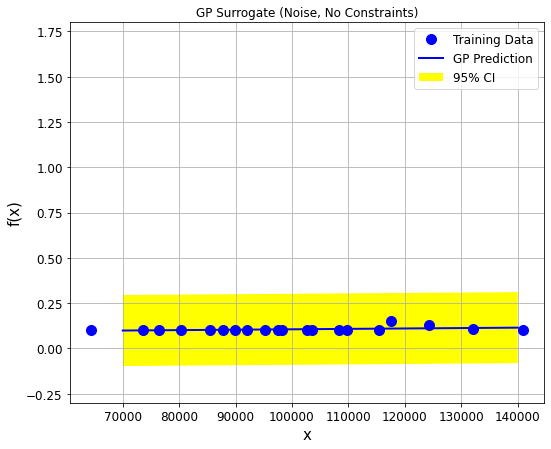

In [14]:
# Solution
from UQpy.sampling import MonteCarloSampling
import matplotlib.pyplot as plt
import numpy as np

domain=np.linspace(0.5e5, 1.4e5).reshape(-1, 1)
prediction_results, y_std2 = K.predict(domain, 
                                       return_std=True)